In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import keras
from keras import layers
from keras.callbacks import EarlyStopping

import tensorflow as tf

In [17]:
# check GPU
from tensorflow.python.client import device_lib
display(tf.config.list_physical_devices("GPU"))
display(device_lib.list_local_devices())

[]

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8626686509213128921
 xla_global_id: -1]

In [2]:
data_file_path = "../datasets/red_wine/datasets/"

In [3]:
# setup plotting
# display(plt.style.available)
plt.style.use("seaborn-v0_8-whitegrid")
# setup defaults
plt.rc("figure", autolayout = True)
plt.rc("axes", labelweight = "bold", labelsize = "large",
       titleweight = "bold", titlesize = 18, titlepad = 10)

In [4]:
red_wine = pd.read_csv(data_file_path + "red_wine.csv")
display(red_wine.shape)
display(red_wine.head())

(1599, 12)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
# pick out random data to train
df_train = red_wine.sample(frac=0.7, random_state=0)

# remove the training data from valid data
df_valid = red_wine.drop(df_train.index)
display(df_train.head())

# NOTE: commented out to test batch normalization
# scale to [0, 1]
# max_ = df_train.max(axis=0)
# min_ = df_train.min(axis=0)
# df_train = (df_train - min_) / (max_ - min_)
# df_valid = (df_valid - min_) / (max_ - min_)
display(df_train.head())

# remove target value from training data
X_train = df_train.drop("quality", axis=1)
X_valid = df_valid.drop("quality", axis=1)
y_train = df_train["quality"]
y_valid = df_valid["quality"]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6
979,12.2,0.450,0.49,1.40,0.075,3.0,6.0,0.99690,3.13,0.63,10.4,5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6
979,12.2,0.450,0.49,1.40,0.075,3.0,6.0,0.99690,3.13,0.63,10.4,5


In [6]:
# keras model
red_wine_model_keras_sequential = keras.Sequential(
    [
        keras.Input((X_train.shape[1],)),
        layers.Dense(2048, activation="relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(2048, activation="relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(2048, activation="relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        layers.Dense(1),
    ]
)

In [7]:
# using "adam" - a "self-tuning" SGD algorithm
red_wine_model_keras_sequential.compile(
    optimizer="adam",
    loss="mae",
)

In [8]:
# train
keras_sequential_early_stopping = EarlyStopping(
    min_delta=0,
    patience=20,
    restore_best_weights=True,
)
history_keras_sequential = red_wine_model_keras_sequential.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=200,
    callbacks=[keras_sequential_early_stopping],
)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 6.6707 - val_loss: 19.7394
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 5.4361 - val_loss: 3.1304
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 5.1106 - val_loss: 10.5615
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 4.8636 - val_loss: 15.0723
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 4.6041 - val_loss: 13.7449
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 4.2809 - val_loss: 10.4099
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 3.9388 - val_loss: 5.4552
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 3.5755 - val_loss: 1.8764
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 3.0474 - val_loss: 2.7003
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 2.5311 - val_loss: 2.4526
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 2.0656 - val_loss: 3.8344
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 1.6

<Axes: >

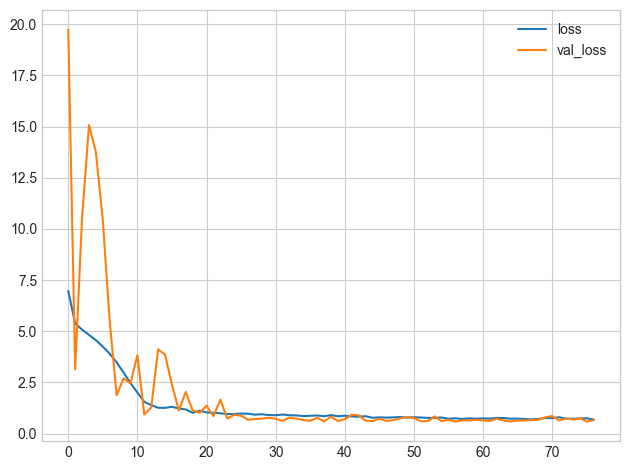

In [9]:
history_keras_sequential_df = pd.DataFrame(history_keras_sequential.history)
history_keras_sequential_df.plot()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


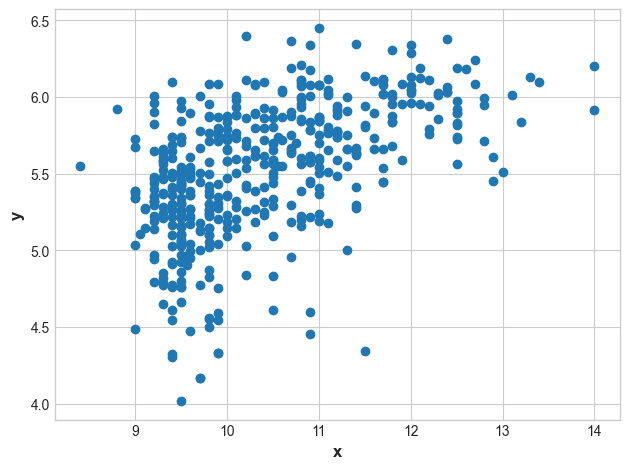

In [10]:
x = X_valid["alcohol"]
y = red_wine_model_keras_sequential.predict(X_valid)

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
w, b = red_wine_model_keras_sequential.get_weights()[:2]
plt.show()